## 2️⃣ Exploratory Data Analysis (EDA)
<!-- **Designed by:** [datamover.ai](https://www.datamover.ai) -->

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
from R2_functions import normal_check
from R2_functions import univariate_outlier_removal


# Set random seed
np.random.seed(42)

**1. Load the train set and sample the dataset to a manageable size if necessary**

This [article](https://www.kaggle.com/code/alexisbcook/data-leakage) explained the necessity to perform EDA on train set only, preventing from data leakage.

In [34]:
# Load data: 
data = pd.read_csv("./data/data_train.csv")
df_train = pd.DataFrame(data) # rename data to df_train

# Similarly, before proceeding to the task, visualise the size of dataset and inspect storage
size_b = df_train.memory_usage(deep=True).sum()  # get size in byte
size_mb = size_b / (1024 * 1024)  # convert byte to mb
print(f"Size data: {size_mb:.2f} Mb")

Size data: 0.10 Mb


In [35]:
# Display train set data table: 
print(df_train.shape)
df_train.head(3)

(554, 7)


,Price,Address,Zip,Area,Room,Lon,Lat
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078 VH,81,3,4.894509,52.343016
1,400000.0,"Jan van Riebeekstraat 3 1, Amsterdam",1057 ZW,61,2,4.858697,52.370661
2,695000.0,"Da Costakade 171 III, Amsterdam",1053 WX,88,3,4.874092,52.367502


In [36]:
# Inspect train set data structure,  
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Price    552 non-null    float64
 1   Address  554 non-null    object 
 2   Zip      554 non-null    object 
 3   Area     554 non-null    int64  
 4   Room     554 non-null    int64  
 5   Lon      554 non-null    float64
 6   Lat      554 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 30.4+ KB


**2. For supervised learning tasks, identify the target attribute(s)**

In [37]:
Y_target = "Price"

**3. Study each attribute and its characteristics:**

**3 a. Name**

In [38]:
df_train.columns

Index(['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat'], dtype='object')

**3 b. For tabular data, define the data type of each variable, namely:**

- `Nominal`: Named categories, e.g., `gender : ['Female', 'Male']`
- `Ordinal`: Categories with an implied order, e.g. `quality : [Low, Medium, High]`
- `Discrete`: Only particular numbers, e.g., `age: {1,2,3,...,58,59,60}`
- `Continuous`: Any numerical value, e.g. `weight: {38.9,45.5}`
    
📝 Nominal and ordinal data types are considered qualitative (**categorical**) features, whereas discrete and continuous data types are considered numerical (**quantitative**) features.

In [39]:
df_train.head()

,Price,Address,Zip,Area,Room,Lon,Lat
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078 VH,81,3,4.894509,52.343016
1,400000.0,"Jan van Riebeekstraat 3 1, Amsterdam",1057 ZW,61,2,4.858697,52.370661
2,695000.0,"Da Costakade 171 III, Amsterdam",1053 WX,88,3,4.874092,52.367502
3,1050000.0,"Koninginneweg 158 4, Amsterdam",1075 EE,119,5,4.860818,52.352776
4,300000.0,"Willem Leevendstraat 1 1, Amsterdam",1055 KB,54,2,4.846858,52.384197


In [40]:
# create a dataframe with dictionary, by specifying the data type of each variable 
df_datatype = pd.DataFrame.from_dict(
    {
        "Price": "continuous",  # <- This is the TARGET variable
        "Address": "nominal",   # <- contains repeat values 
        "Zip": "nominal",       # <- contains repeat values 
        "Area": "continuous",   
        "Room": "discrete",
        "Lon": "continuous",
        "Lat": "continuous",
    },
    orient="index",
    columns=["data_type"],
)

df_datatype.transpose()       # transposed vector to keep this notebook tidy 

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,nominal,nominal,continuous,discrete,continuous,continuous


3b.1 Exploring quantitative variables (i.e., continous & discrete)

In [41]:
# Summary descriptive statistic for continous variables 
df_train.nunique(axis=0)
#from a glance of variable count, it appears to have missing data in Target variable (i.e., Price)
df_train.describe().apply(lambda s: s.apply(lambda x: format(x, '.3f')))


,Price,Area,Room,Lon,Lat
count,552.000,554.000,554.000,554.000,554.000
mean,611200.743,94.700,3.527,4.887,52.364
std,516752.981,55.055,1.519,0.053,0.024
min,175000.000,21.000,1.000,4.655,52.292
25%,350000.000,60.000,3.000,4.854,52.352
50%,462000.000,82.000,3.000,4.887,52.364
75%,695000.000,111.000,4.000,4.921,52.378
max,5950000.000,497.000,14.000,5.029,52.424


3b.2 Exploring variables that were stored as string objects 

In [42]:
# inspect for string variables 
print(f"Address: \
      { 100*len(df_train['Address'].unique())/len(df_train['Address']):.2f}% were unique values ({len(df_train['Address'].unique())} out of {len(df_train['Address'])} total values)")

print(f"Zip: \
      { 100*len(df_train['Zip'].unique())/len(df_train['Zip']):.2f}% were unique values ({len(df_train['Zip'].unique())} out of {len(df_train['Zip'])} total values)")


Address:       99.64% were unique values (552 out of 554 total values)
Zip:       93.32% were unique values (517 out of 554 total values)


In [43]:
    # display categorical values that shown repeatedly in the dataset
    # the output indicated interesting patterns that 
    # proportionate of houses on sale were concentrated in certain zip areas / sharing same addresses
cat_data = df_train.select_dtypes(include=['object'])
cat_data.value_counts().reset_index(name="count").query("count > 1")

    # Zip concentration in details: 
# df_train['Zip'].value_counts().reset_index(name="count").query("count > 1")

    # breakdown to address, zip concentration respectively:
# for colname in cat_data.columns:
#     print (colname)
#     print (df_train[colname].value_counts(), '\n')

,Address,Zip,count
0,"Uilengouw 2, Amsterdam",1027 EZ,2
1,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2


**3 c. Percentage of missing values, namely** `np.NaN` 
- [missingno](https://github.com/ResidentMario/missingno) can be a useful tool for visualization;
- Ensure that missing values are not encoded in a specific ways, e.g. `-1`, `"?"`
- Inspect rows with missing values to assess if a specific pattern exists. 

<!-- Missingo example -->
<!-- # import missingno as msno
# %matplotlib inline
# msno.matrix(df_train.sample(df_train.shape[0]))

# # msno.bar(df_train.sample(len(df_train))) -->

In [44]:
print(f"{df_train.isna().sum().sum()} missing values from train set\
      ({df_train.isna().sum().sum()/df_train.shape[0]*df_train.shape[1]:.2f}%) ")

missing = pd.DataFrame(df_train.isna().any(), columns=['Contains_missing'])

missing.replace({True: 'Yes',
                False: 'No'
                 }, inplace=True)

missing_count= pd.DataFrame(df_train.isna().sum(), columns=['Missing_Counts'])

df_missing = missing.merge(missing_count, how ='outer', left_index= True, right_index= True)
df_missing.reset_index(inplace=True)
df_missing.rename(columns={'index': 'col_name'}, inplace= True)
df_missing.set_index("col_name", inplace= True)
df_missing.transpose()

2 missing values from train set      (0.03%) 


col_name,Price,Address,Zip,Area,Room,Lon,Lat
Contains_missing,Yes,No,No,No,No,No,No
Missing_Counts,2,0,0,0,0,0,0


In [45]:
# print samples with missing values
display(df_train[df_train.isna().any(axis=1)])

,Price,Address,Zip,Area,Room,Lon,Lat
271,NaN,"Zeeburgerkade 760, Amsterdam",1019 HT,107,3,4.945022,52.369244
408,NaN,"Suikerplein 16, Amsterdam",1013 CK,81,3,4.880976,52.389623


All missing values from train set are on the target `Price`. 

Given it's unclear on the mechanisms of missingness (i.e., missing completely at random vs. missing at random vs. missing not at random), I will ignore these two 2 observations showed above, judging by their small impact on the entire dataset (0.03%).   

**3 d. Check if there are any duplicates and inspect them;**

In [46]:
# check if there are duplicated rows in the dataset
print(f" {df_train.duplicated().sum()} duplicate values from train set ({df_train.duplicated().sum()/len(df_train):.3f}%) ")

 0 duplicate values from train set (0.000%) 


* There are other method such as detecting similar features via [fastML package](https://towardsdatascience.com/2-types-of-duplicate-features-in-machine-learning-2931de6c949b) has been suggested for duplicate handling prior to model selection. 

* Given the limited variables included in current dataset, as well as descriptive statistics showed above, I decided not to include further test for this. 



**3 e. Noisiness and type of noise e.g. stochastic, rounding errors, etc.** (might require business knowledge)


In [47]:
# Assuming that we have noise-free features
df_type_noise = pd.DataFrame(
    data={"type of noise": len(df_train.columns)* ["noise-free"]}, index=df_train.columns
)

df_type_noise.transpose()

,Price,Address,Zip,Area,Room,Lon,Lat
type of noise,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free


**3 f. The frequency of each group within categorical variables and the type of distribution for numerical variables** 

Checked this [link](https://www.itl.nist.gov/div898/handbook/eda/section3/eda366.htm) for common types of distributions. It is recommended to visualise each variable by using:
- a [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) for categorical variables;
- a [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot) for numerical variables.

In [48]:
# Recall predefined data type of each variable
df_datatype.transpose()

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,nominal,nominal,continuous,discrete,continuous,continuous


In [49]:
# Create an ad-hoc function for this task
def get_feature_list(df_datatype: pd.DataFrame, datatype: str) -> list:
    """Get a list of features of a given datatype
    Args:
        df_datatype (pd.DataFrame): dataframe with the datatype of each feature
        datatype (str): datatype of interest

        Returns:
        list: list of features of a given datatype
    """

    list_dtype = df_datatype.loc[lambda x: x["data_type"] == datatype].index.to_list() # define list of callable features from later user input
    
    print(f"• {len(list_dtype)} {datatype.upper()} variables found in the dataset")  # print number of features of interest
    
    print(f"• list = {list(list_dtype)}") # print list of features names 

    return list_dtype

##### Inspect on qualitative variables 
- Visualize `nominal` variables

In [50]:
DATATYPE = "nominal"

list_nominal = get_feature_list(df_datatype=df_datatype, datatype=DATATYPE)

print(
    "NOTE: We will skip for now the visualization of nominal features as we do not have a good way to visualize them."
)

• 2 NOMINAL variables found in the dataset
• list = ['Address', 'Zip']
NOTE: We will skip for now the visualization of nominal features as we do not have a good way to visualize them.


- Visualize `ordinal` variables

In [51]:
DATATYPE = "ordinal"
list_ordinal = get_feature_list(df_datatype=df_datatype, datatype=DATATYPE)

• 0 ORDINAL variables found in the dataset
• list = []


##### Inspect on quatitative variables 

- Visualize `discrete` and `continuous` variables together

In [52]:
DATATYPE = "discrete"
list_discrete = get_feature_list(df_datatype=df_datatype, datatype=DATATYPE)

• 1 DISCRETE variables found in the dataset
• list = ['Room']


In [53]:
DATATYPE = "continuous"
list_continuous = get_feature_list(df_datatype=df_datatype, datatype=DATATYPE)

• 4 CONTINUOUS variables found in the dataset
• list = ['Price', 'Area', 'Lon', 'Lat']


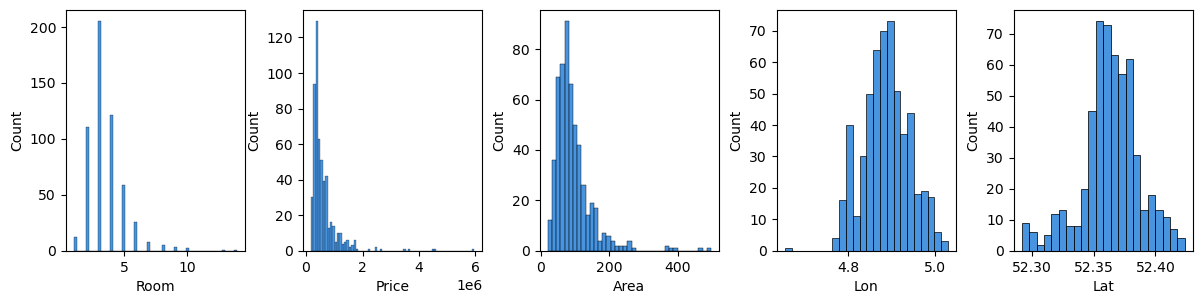

In [54]:
# combine all lists to visualise all numerical features
list_numerical = list_discrete + list_continuous

# visualise the data by checking histogram of numeric columns 
fig, axs = plt.subplots(nrows=1, ncols=len(list_numerical), figsize=(12, 3))
fig.tight_layout(w_pad=1.05)


for i, ax in enumerate(axs.flatten()):
    sns.histplot(
        data=df_train,
        x=list_numerical[i],
        discrete=False,
        ax=ax,
        color="#0B70D4"
    )


To further check whether data follows a normal distribution: I used kolmogorov-smirnov test instead of shapiro-wilk test, as it is more robust to larger sample size (e.g., N > 50). The Kolmogorov-Smirnov test is used to test the null hypothesis that a set of data comes from a normal distribution.

In [55]:
from R2_functions import normal_check
normal_check(df_train)

,feature,p-value,normality
0,Price,0.000,False
1,Area,0.000,False
2,Room,0.000,False
3,Lon,0.459,True
4,Lat,0.001,False


Moreover, we can further indentify **empirical distribution** of each numeric variable: 

In [56]:
from fitter import Fitter, get_common_distributions, get_distributions

# function to identify the empirical distribution of a variable
def get_best_distribution(df):
    dist_names = get_common_distributions() # get list of most common distribution names
    dist_results = []
    params = {}
    
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(df)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(df, dist_name, args=param,method='approx')
        # print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    
    # store the name of the best fit and its p value
    # print("Best fitting distribution: "+str(best_dist))
    # print("Best p value: "+ str(best_p))
    # print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist #, best_p, params[best_dist]



In [57]:
check_dist = df_train.dropna().select_dtypes([np.int64, np.float64]) #get numeric columns only 

for (colname,colval) in check_dist.items():
    print(f"• Best distribution for {colname} is: {get_best_distribution(check_dist[colname])} ")

• Best distribution for Price is: lognorm 
• Best distribution for Area is: lognorm 
• Best distribution for Room is: chi2 
• Best distribution for Lon is: norm 
• Best distribution for Lat is: cauchy 


* As can be observed from the results, only `Lon` column from the orignal dataset is normally distributed, where the rest are not. 

**3. g Examine possible outliers in numerical variables and check whether they make sense (might require business knowledge).** 

For details on identifying outliers, refer to this [link](https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/).

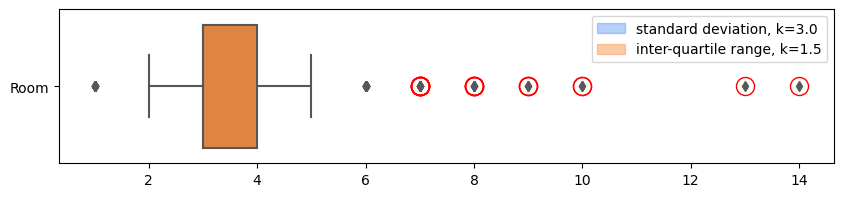

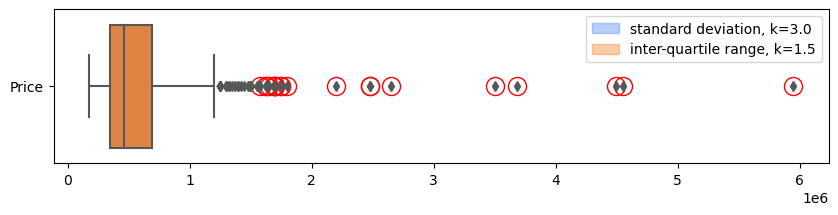

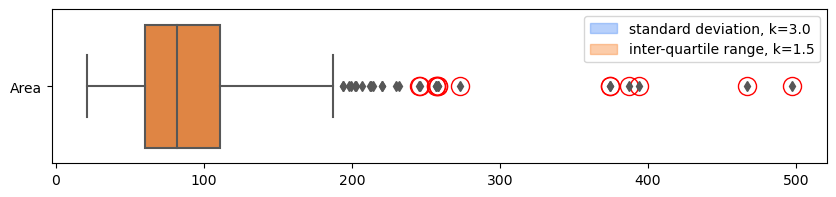

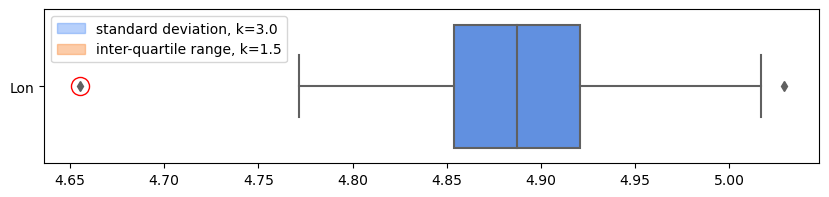

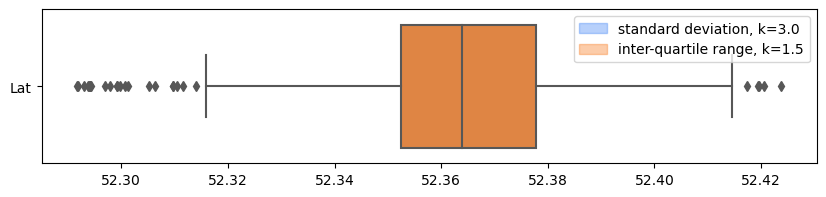

In [58]:
from R2_functions import univariate_outlier_removal

for num_var in list_numerical:
    _, summary_outlier, fig = univariate_outlier_removal(
        df=data[num_var].to_frame(),
        nonparam_args={"factor": 2.5},
        remove=False,
        plot=True,
        figsize=(10, 2),
    )

**4. Annotate all information from EDA, such as:**
- the type of data;
- if there are missing values and how to deal with them;
- summary statistics of both numerical and categorical variables;
- the type of distribution; 
- identify the promising transformations you may want to apply (e.g. log-transformation for highly skewed distribution or cluster facets to mitigate group imbalance);
- identify additional data sources that would be useful;
- anything else that is noteworthy for model training.

In [59]:
# Show information regarding type of data, missing values and noise
data_info = df_datatype.join(df_missing).join(df_type_noise)
display(data_info.transpose())

# Save data_type into a csv file
data_info["data_type"].to_csv("./data/data_info.csv")

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,nominal,nominal,continuous,discrete,continuous,continuous
Contains_missing,Yes,No,No,No,No,No,No
Missing_Counts,2,0,0,0,0,0,0
type of noise,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free


Missing values are observed only in the target `Price`. These samples will be discarded during model training.

In [63]:
# display summary statistics
#quantitative variables summary statistics
display(data[list_discrete + list_continuous].describe().round(2))
#quanlitative variables summary statistics
display(data[list_nominal + list_ordinal].describe())

,Room,Price,Area,Lon,Lat
count,554.00,552.00,554.00,554.00,554.00
mean,3.53,611200.74,94.70,4.89,52.36
std,1.52,516752.98,55.05,0.05,0.02
min,1.00,175000.00,21.00,4.66,52.29
25%,3.00,350000.00,60.00,4.85,52.35
50%,3.00,462000.00,82.00,4.89,52.36
75%,4.00,695000.00,111.00,4.92,52.38
max,14.00,5950000.00,497.00,5.03,52.42


,Address,Zip
count,554,554
unique,552,517
top,"Uilengouw 2, Amsterdam",1017 KP
freq,2,3


- We observe that `Room`,  `Price` and  `Area` are highly skewed. Conversely, `Lon` and `Lat` are relatively normally distributed. We will attempt to normalize the skewed variables using a log transformation.
- Both `Address` and `Zip` have significant unique values, making it challenging to leverage both features for model prediction. We will attempt to extract features using business knowledge.
- It is hypothesized that additional variables such as energy label, year of building, and information regarding a front or back garden if any, and type of house would be valuable information to enhance the model performances.

In [61]:
# Provide some additonial information
print(
    f"• The Mininum value of {Y_target} is {int(data[Y_target].min())} EUR with an Area of {data.loc[data[Y_target].idxmin(), 'Area']} m2 and {data.loc[data[Y_target].idxmin(), 'Room']} room"
)
print(
    f"• The Maximum value of {Y_target} is {int(data[Y_target].max())} EUR with an Area of {data.loc[data[Y_target].idxmax(), 'Area']} m2 and {data.loc[data[Y_target].idxmax(), 'Room']} room"
)

• The Mininum value of Price is 175000 EUR with an Area of 28 m2 and 1 room
• The Maximum value of Price is 5950000 EUR with an Area of 394 m2 and 10 room
